# Quark-Gluon Jet Discrimination

In [1]:
%matplotlib inline
import sys
from collections import namedtuple
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

from dataset import load_qgjets_dataset

In [2]:
print(sys.version)
print(tf.version.VERSION)
print(tfp.__version__)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
1.14.0
0.7.0


In [3]:
seed = 0
random_state = 0
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

# Data Loading and Preprocessing
*  [sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [4]:
x_train, y_train, feature_names = load_dataset('training', with_feature_names=True)
x_valid, y_valid = load_dataset('validation')
x_test, y_test = load_dataset('test')

In [5]:
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_valid = minmax.transform(x_valid)
x_test = minmax.transform(x_test)

Datasets = namedtuple('Datasets', ['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test'])
datasets = Datasets(x_train, y_train, x_valid, y_valid, x_test, y_test)

# Data Visualization

In [6]:
num_vis = min(len(x_test), 500)
vis_indices = np.random.choice(np.arange(len(x_test)), num_vis)
x_vis = x_test[vis_indices]
y_vis = y_test[vis_indices]

In [7]:
df = {name: x_vis[:, idx] for idx, name in enumerate(feature_names)}
variables = list(df.keys())
print(variables)
df['y'] = y_vis[:, 1]
df = pd.DataFrame(df)

['ptd', 'major_axis', 'minor_axis', 'chad_mult', 'nhad_mult', 'photon_mult', 'electron_mult', 'muon_mult']


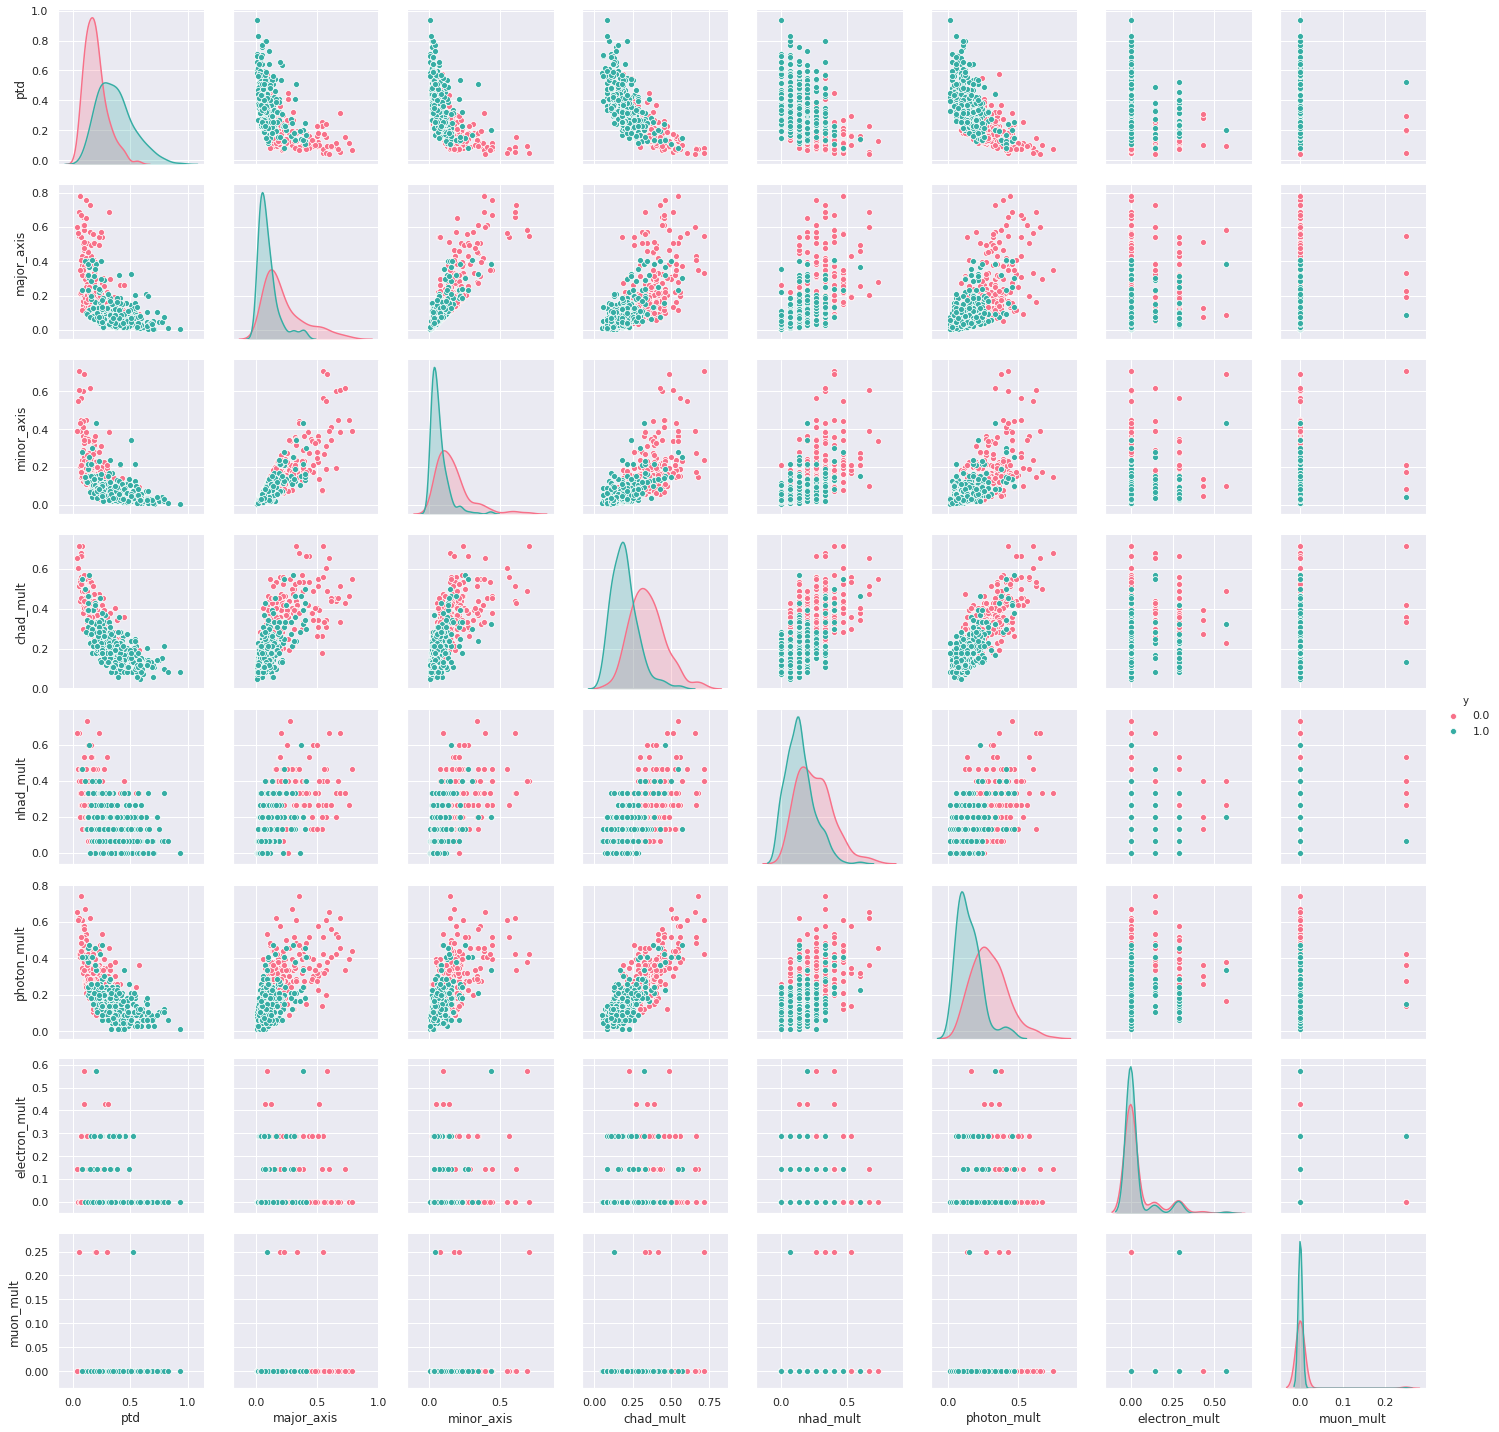

In [8]:
sns.pairplot(df, hue='y', vars=variables, palette="husl")

Text(0.5, 1.0, 't-SNE')

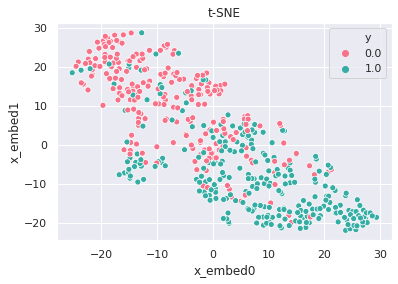

In [9]:
tsne = TSNE(random_state=random_state)
x_embed = tsne.fit_transform(x_vis)
df['x_embed0'] = x_embed[:, 0]
df['x_embed1'] = x_embed[:, 1]
ax = sns.scatterplot(data=df, x='x_embed0', y='x_embed1', hue='y', palette="husl")
ax.set_title("t-SNE")

In [10]:
def plot_learning_curve(history, title=None):
    kwargs = {'ls': '--', 'marker': 'o'}

    fig, axarr = plt.subplots(ncols=2, figsize=(16, 6))
    axarr[0].plot(history.history['loss'], label='Training', **kwargs)
    axarr[0].plot(history.history['val_loss'], label="Validation", **kwargs)
    axarr[0].set_title("Loss")
    axarr[0].set_xlabel('Epoch')
    axarr[0].legend()

    axarr[1].plot(history.history['acc'], label='Training', **kwargs)
    axarr[1].plot(history.history['val_acc'], label="Validation", **kwargs)
    axarr[1].set_title("Accuracy")
    axarr[1].set_xlabel('Epoch')
    axarr[1].legend()
    
    if title is not None:
        fig.suptitle(title)

In [11]:
def run_experiment(model,
                   loss,
                   datasets,
                   title=None,
                   learning_rate=0.01,
                   epochs=100,
                   batch_size=256):
    
    model.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=loss,
        metrics=['accuracy'])

    history = model.fit(
        datasets.x_train,
        datasets.y_train,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        validation_data=(datasets.x_valid, datasets.y_valid),
        verbose=False)


    loss, acc = model.evaluate(datasets.x_test, datasets.y_test, verbose=False)
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    
    
    # plotting
    plot_learning_curve(history, title)
    
    return acc

# Deterministic Deep Model

In [12]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfkl.Dense(128),
    tfkl.ReLU(),
    tfkl.Dense(y_train.shape[-1]),
    tfkl.Softmax(),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
softmax (Softmax)            (None, 2)                 0         
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________


W0708 13:28:21.784873 140489889109824 deprecation.py:323] From /home/slowmoyang/Installations/anaconda3/envs/py36-tf114/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Loss: 0.4786
Accuracy: 0.7727


0.7727

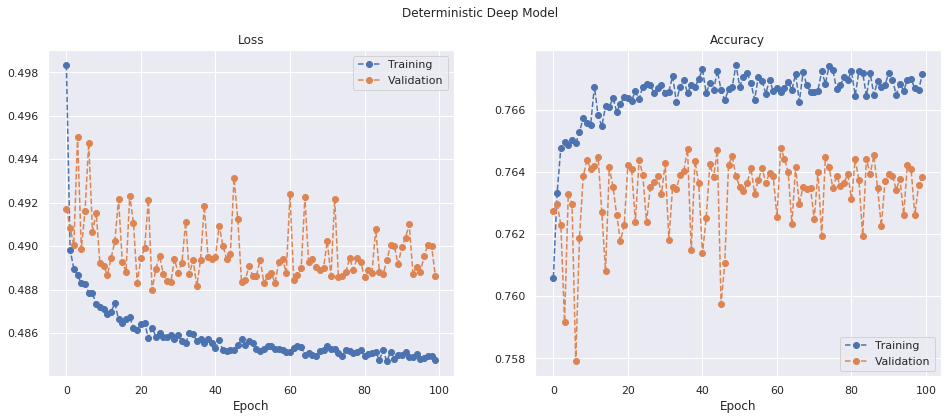

In [13]:
model.set_weights(initial_weights)

run_experiment(
    model,
    loss=tfk.losses.categorical_crossentropy,
    datasets=datasets,
    title='Deterministic Deep Model',
    learning_rate=0.01,
    epochs=100)

# Create probabilistic model
*  [Probabilistic Layer Regression](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb)
*  [OneHotCategorical](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/OneHotCategorical)

In [14]:
kl_weight = 1 / len(x_train)
print(kl_weight)

7.142857142857143e-06


In [15]:
def negative_log_likelihood(y_true, y_pred_rv):
    return -y_pred_rv.log_prob(y_true)

In [16]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    # NOTE When c = np.log(np.expm1(1.)), training is very unstable
    # c = np.log(np.expm1(1.))
    c = 0
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(
                    loc=t[..., :n],
                    scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
  ])

In [17]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1),
                reinterpreted_batch_ndims=1)),
    ])

In [18]:
def evaluate(model, x, y):
    samples = tf.stack([model(x).probs for _ in range(100)]).numpy()[:, :, 1]
    y_hat = samples.mean(axis=0)
    y = y[:, 1]
    accuracy = ((y_hat > 0.5).astype(int) == y).mean()
    print(f"Accuracy: {accuracy}")
    return accuracy

# Bayesian Shallow Model

In [20]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfpl.DenseVariational(
        units=tfpl.OneHotCategorical.params_size(y_train.shape[-1]) - 1,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfk.layers.Lambda(lambda x: tf.pad(x, paddings=[[0, 0], [1, 0]])),
    tfpl.OneHotCategorical(y_train.shape[-1]),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_1 (DenseVa (None, 1)                 27        
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 2), (None, 2))    0         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


Loss: 0.4986
Accuracy: 0.6715
Accuracy: 0.76645


0.76645

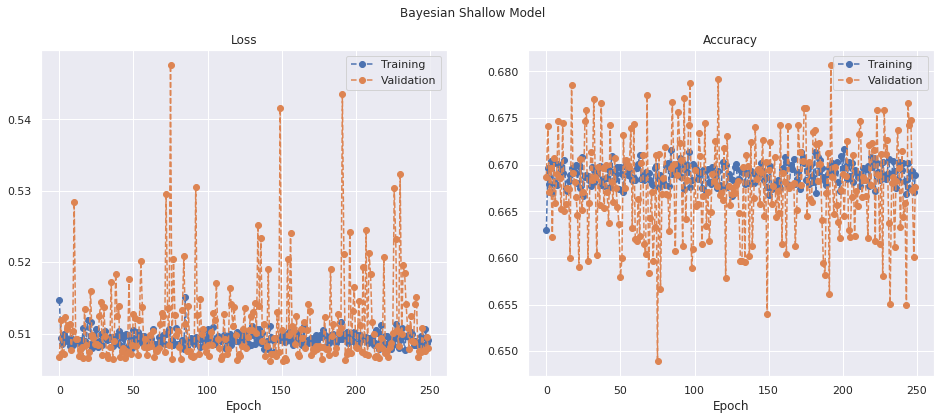

In [21]:
model.set_weights(initial_weights)

run_experiment(model,
               loss=negative_log_likelihood,
               datasets=datasets,
               title='Bayesian Shallow Model',
               learning_rate=0.5,
               epochs=250)

evaluate(model, datasets.x_test, datasets.y_test)

Loss: 0.4973
Accuracy: 0.6717
Accuracy: 0.76725


0.76725

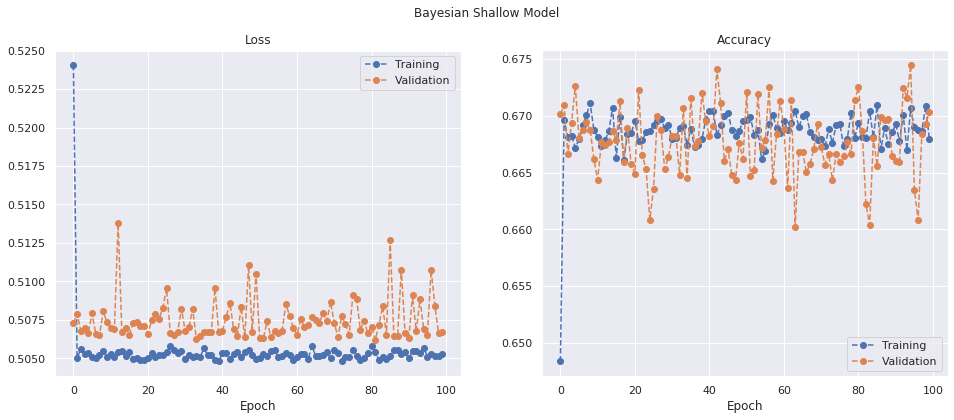

In [22]:
model.set_weights(initial_weights)

run_experiment(model,
               loss=negative_log_likelihood,
               datasets=datasets,
               title='Bayesian Shallow Model',
               learning_rate=0.1,
               epochs=100)

evaluate(model, datasets.x_test, datasets.y_test)

Loss: 0.4975
Accuracy: 0.6694
Accuracy: 0.76605


0.76605

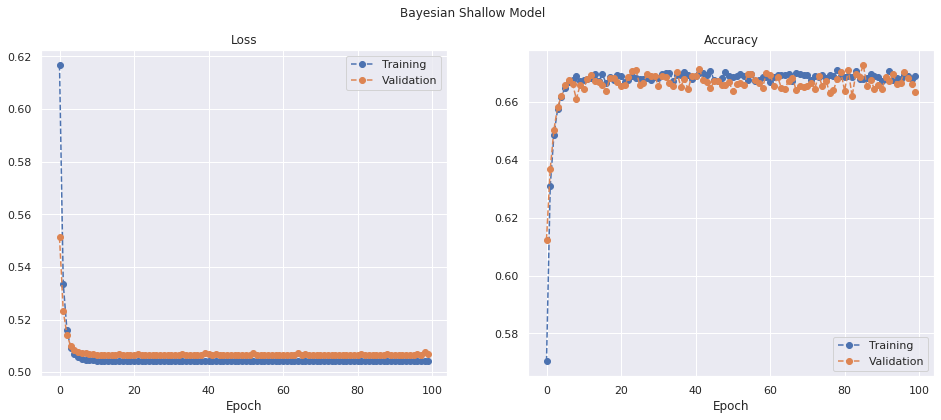

In [23]:
model.set_weights(initial_weights)

run_experiment(model,
               loss=negative_log_likelihood,
               datasets=datasets,
               title='Bayesian Shallow Model',
               learning_rate=0.01,
               epochs=100)
 
evaluate(model, datasets.x_test, datasets.y_test)

# Deep Bayesian Model

In [24]:
model = tf.keras.Sequential([
    tfkl.InputLayer(x_train.shape[1:]),
    tfpl.DenseVariational(
        units=128,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfkl.ReLU(),
    tfpl.DenseVariational(
        units=tfpl.OneHotCategorical.params_size(y_train.shape[-1]) - 1,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight),
    tfk.layers.Lambda(lambda x: tf.pad(x, paddings=[[0, 0], [1, 0]])),
    tfpl.OneHotCategorical(y_train.shape[-1]),
])

model.summary()

initial_weights = model.get_weights()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_2 (DenseVa (None, 128)               3456      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_variational_3 (DenseVa (None, 1)                 387       
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
_________________________________________________________________
one_hot_categorical_2 (OneHo ((None, 2), (None, 2))    0         
Total params: 3,843
Trainable params: 3,843
Non-trainable params: 0
_________________________________________________________________


Loss: 0.4869
Accuracy: 0.6770
Accuracy: 0.764625


0.764625

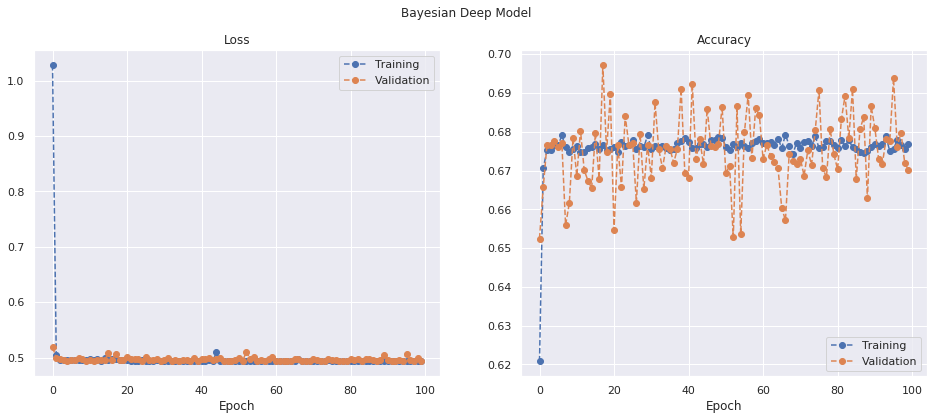

In [25]:
model.set_weights(initial_weights)

run_experiment(model,
               loss=negative_log_likelihood,
               datasets=datasets,
               title='Bayesian Deep Model',
               learning_rate=0.1,
               epochs=100)


evaluate(model, datasets.x_test, datasets.y_test)

Loss: 0.4822
Accuracy: 0.6836
Accuracy: 0.7703


0.7703

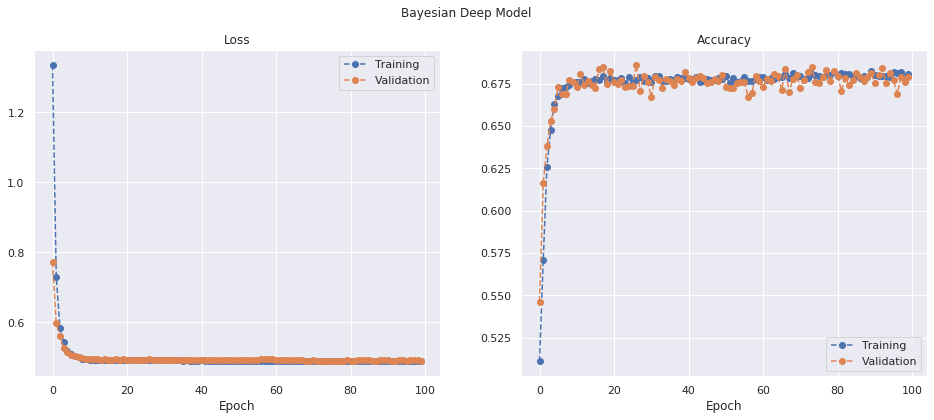

In [26]:
model.set_weights(initial_weights)


run_experiment(model,
               loss=negative_log_likelihood,
               datasets=datasets,
               title='Bayesian Deep Model',
               learning_rate=0.01,
               epochs=100)

evaluate(model, datasets.x_test, datasets.y_test)